# Constructing final spectra

In [15]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

def load_runs(runs,bt):
    '''
    Load hdf5-file from runs, containing
        (x,y) coordinates of droplets [dim ndroplets]
        intensity of droplets         [dim ndroplets]
        number of droplets            [dim nshots]
        intensity of pulses           [dim nshots]
        
    Call: x,y,adi,ndrop,gmd = load_runs([run1,run2,...],bt)
    '''
    x = []; y = []; adu = []; ndrop = []; gmd = []
    for run in runs:
        if bt == 'instruction':
            fh = h5py.File('../../example_data/run-%03d.h5' %run, 'r')
            X  = fh['x'][()]; Y = fh['y'][()]; I = fh['adu'][()]
            N  = fh['ndroplets'][()]; E = fh['pulse_energy'][()]
            fh.close()
        x.append(X); y.append(Y); adu.append(I),ndrop.append(N); gmd.append(E)
    return np.concatenate(x),np.concatenate(y),np.concatenate(adu),np.concatenate(ndrop),np.concatenate(gmd)

def det_geom(img,bt):
    '''
    Correct image for detector geometry
    '''
    if bt == 'instruction':
        new_img = [];  I = 0
        for i in np.arange(709):
            if (i > 352) and (i < 358):  new_img.append(np.zeros(len(img[0])+5))
            else:
                tmp = img[I]
                for j in np.arange(5): tmp = np.insert(tmp, 384, 0.0)
                new_img.append(tmp); I += 1
    return new_img

def create_img_v1(x,y,adu,ndrop,adu_int,scale_signal):
    '''
    Version 1 of a script which creates the full image
    
    Call: img = create_img_v1(x,y,adu,ndrop,adu_interval,scale_signal)
    '''
    ind, = np.where((adu >= adu_int[0]) & (adu <= adu_int[1]))
    if scale_signal == True:    img, xedges, yedges = np.histogram2d(x[ind], y[ind], bins=[np.arange(705), np.arange(769)],weights=adu[ind])
    elif scale_signal == False: img, xedges, yedges = np.histogram2d(x[ind], y[ind], bins=[np.arange(705), np.arange(769)])
    det_geom(img,'instruction')
    return img

def create_img(x,y,adu,ndrop,adu_int,scale_signal):
    '''
    Create image with some ADU signals
    
    Call: img = create_img_v1(x,y,adu,ndrop,adu_interval,scale_signal)
    '''
    ind, = np.where((adu >= adu_int[0]) & (adu <= adu_int[1]))
    if scale_signal == True:    img, xedges, yedges = np.histogram2d(x[ind], y[ind], bins=[np.arange(705), np.arange(769)],weights=adu[ind])
    elif scale_signal == False:
        img_1ph, xedges, yedges = np.histogram2d(x[ind], y[ind], bins=[np.arange(705), np.arange(769)])
        ind, = np.where((adu >= 2.0*adu_int[0]) & (adu <= 2.0*adu_int[1]))
        img_2ph, xedges, yedges = np.histogram2d(x[ind], y[ind], bins=[np.arange(705), np.arange(769)])
        img = img_1ph + 2.0*img_2ph # scale 2-photon image by factor 2
    det_geom(img,'instruction')
    return img

def plot_raw(runs,roi,adu_int,plot_results,bt):
    '''
    Plot histogram, detector image, and projections
    Can include an ROI or do this over full image
    
    Call: spat_spec,xes_spec = plot_raw(runs,roi,adu_int,plot_results,bt)
    '''
    x,y,adu,ndrop,gmd = load_runs(runs,bt)
    print('Looking at runs {}-{} from expt \'{}\', with {:.2e} shots and {:.2e} droplets.'.format(runs[0],runs[len(runs)-1],bt,len(ndrop),sum(ndrop)))
    img = create_img(x,y,adu,ndrop,adu_int,False)
    spat_spec = np.sum(img, axis=0)/len(ndrop)
    xes_spec  = np.sum(img, axis=1)/len(ndrop)
    
    if plot_results == True:
        plt.figure(figsize=(16,4))
        plt.subplot(141); plt.title('Detector image')
        vmin, vmax = np.percentile(img, [1, 99])
        plt.imshow(img, origin='lower',vmin=vmin, vmax=vmax,aspect='auto')
        if roi != False:
            plt.plot([roi[2],roi[2]],[roi[0],roi[1]],'w--')
            plt.plot([roi[3],roi[3]],[roi[0],roi[1]],'w--')
            plt.xlim((0,len(img[0]))); plt.ylim((0,len(img)))
        plt.subplot(142); plt.title('Spatial projection')
        plt.plot(spat_spec,'b')
        plt.plot([roi[2],roi[2]],[0,max(np.sum(img, axis=0)/len(ndrop))],'r--')
        plt.plot([roi[3],roi[3]],[0,max(np.sum(img, axis=0)/len(ndrop))],'r--')
        plt.xlim((roi[2]-50,roi[3]+50))
        plt.ylabel('Signal / no. shots')
        plt.subplot(143); plt.title('Energy-dispersive projection')
        plt.plot(xes_spec,'b')
        plt.ylabel('Signal / no. shots')
        plt.subplot(144); plt.title('Histogram')
        ind, = np.where((y >= roi[2]) & (y <= roi[3]))
        p = np.percentile(adu[ind], 99.9) # 99.9th percentile, for xmax
        hist, bin_edges = np.histogram(adu[ind],bins = np.arange(0,p,p/500.))
        ylims = [0.0001*np.max(hist),1.1*np.max(hist)]
        plt.plot([adu_int[0],adu_int[0]],ylims,'-',color='r')
        plt.plot([adu_int[1],adu_int[1]],ylims,'-',color='r')
        plt.plot(bin_edges[1:]-0.5,hist,'b'); plt.yscale('log')
        plt.tight_layout()
    return spat_spec,xes_spec

Looking at runs 1-1 from expt 'instruction', with 7.77e+03 shots and 1.58e+06 droplets.


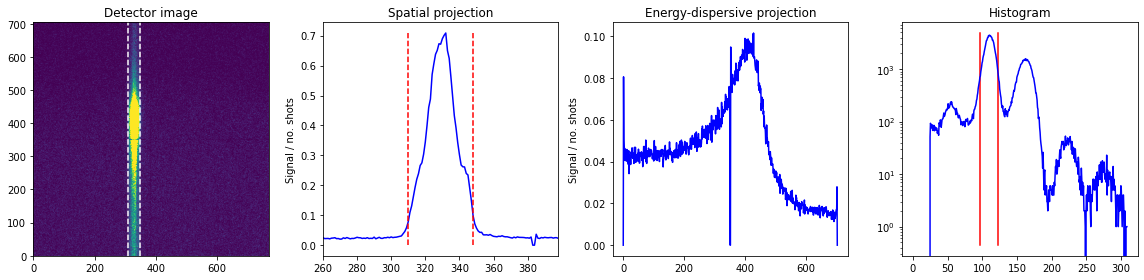

In [28]:
runs    = [1]
adu_int = [97.0,123.0]
roi     = [0,705,310,348]
bt      = 'instruction'
adu_int = [97.0,123.0]
x,y,adu,ndrop,gmd = load_runs(runs,bt)
img = create_img(x,y,adu,ndrop,adu_int,False)

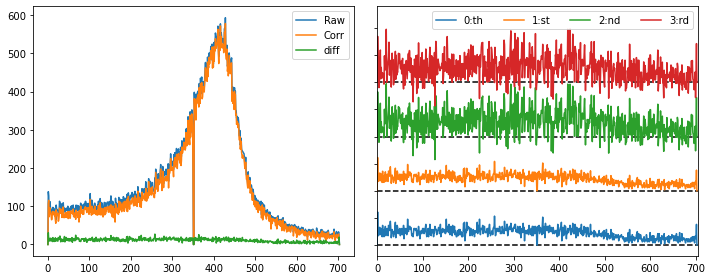

In [53]:
def remove_background_order(img, a, b, c, d, o):
    x = np.concatenate((np.arange(a, b), np.arange(c, d)))
    img_corrected = np.copy(img)
    for i in range(img.shape[0]):
        y = np.concatenate((img[i, a:b], img[i, c:d]))
        poly = np.poly1d(np.polyfit(x, y, o))
        img_corrected[i, :d] = img[i, :d] - poly(np.arange(d))
    return img_corrected

fit = [284,304,358,378]

raw_spec = np.sum(img[roi[0]:roi[1]:,roi[2]:roi[3]], axis=1)
zer_spec = np.sum(remove_background_order(img, fit[0], fit[1], fit[2], fit[3],0)[roi[0]:roi[1]:,roi[2]:roi[3]], axis=1)
one_spec = np.sum(remove_background_order(img, fit[0], fit[1], fit[2], fit[3],1)[roi[0]:roi[1]:,roi[2]:roi[3]], axis=1)
two_spec = np.sum(remove_background_order(img, fit[0], fit[1], fit[2], fit[3],2)[roi[0]:roi[1]:,roi[2]:roi[3]], axis=1)
thr_spec = np.sum(remove_background_order(img, fit[0], fit[1], fit[2], fit[3],3)[roi[0]:roi[1]:,roi[2]:roi[3]], axis=1)

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(raw_spec); plt.plot(one_spec); plt.plot(raw_spec-one_spec)
plt.legend(('Raw','Corr','diff'))

plt.subplot(122)
plt.plot(raw_spec-zer_spec); plt.plot(raw_spec-one_spec+50)
plt.plot(raw_spec-two_spec+100); plt.plot(raw_spec-thr_spec+150)
plt.plot([0,705],[0,0],'k--',zorder=1);     plt.plot([0,705],[50,50],'k--',zorder=1)
plt.plot([0,705],[100,100],'k--',zorder=1); plt.plot([0,705],[150,150],'k--',zorder=1)
plt.legend(('0:th','1:st','2:nd','3:rd'),ncol=4)
plt.yticks([0,25,50,75,100,125,150,175,200],[])
plt.xlim((0,705)); plt.ylim((-10,220))
plt.tight_layout(); plt.show()

In [ ]:
def remove_background(img, a, b, c, d):
    x = np.concatenate((np.arange(a, b), np.arange(c, d)))
    img_corrected = np.copy(img)
    for i in range(img.shape[0]):
        y = np.concatenate((img[i, a:b], img[i, c:d]))
        poly = np.poly1d(np.polyfit(x, y, 1))
        img_corrected[i, :d] = img[i, :d] - poly(np.arange(d))
    return img_corrected

In [ ]:
# bring to zero
#
#

In [ ]:
# remove footprint
# 
#

In [ ]:
# interpolation
#
#
def interpolate_epix_gap(spectrum,bt):
    if (bt == 'LR81'):
        a, b = 309, 349; c, d = 361, 401
    xaxis = np.arange(spectrum.shape[0])
    x = np.concatenate((xaxis[a:b], xaxis[c:d]))
    y = np.concatenate((spectrum[a:b], spectrum[c:d]))
    poly = np.poly1d(np.polyfit(x, y, 2))
    spectrum[b:c] = poly(xaxis[b:c]) 

In [ ]:
# energy calibration
#
#
def energy_axis(A,R,bt):
    d = 0.9601
    if (bt == 'LR81'):
        pix = 0.05; l = np.arange(709).astype(np.float64)
    l *= pix
    ll = l/2 - (np.amax(l) - np.amin(l)) / 4
    factor = 1.2398e4
    xaxis = factor / (2.0*d*np.sin(np.arctan(R/(ll + A))))
    return xaxis

axis_para = [50.72,498.21]

In [ ]:
proj_spectrum_v1
if axis_para == False:
    xaxis = False
else:
    xaxis = energy_axis(axis_para[0],axis_para[1],bt)
        
check with different ADU intervals

Looking at runs 1-6 from beamtime 'instruction', with 6.33e+04 shots.
Looking at runs 1-6 from beamtime 'instruction', with 6.33e+04 shots.
Looking at runs 1-6 from beamtime 'instruction', with 6.33e+04 shots.


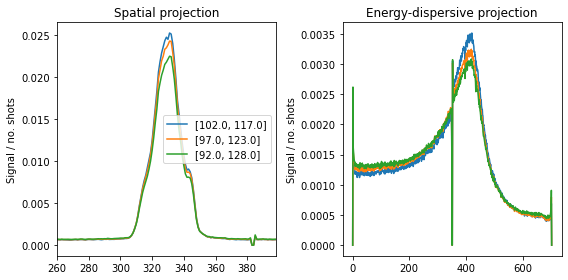

In [10]:
runs = [1,2,3,4,5,6]
plt.figure(figsize=(8,4))
ax0 = plt.subplot(121); plt.title('Spatial projection')
ax1 = plt.subplot(122); plt.title('Energy-dispersive projection')

adu_ints = [[102.0,117.0],[97.0,123.0],[92.0,128.0]]
for adu_int in adu_ints:
    spat_spec,xes_spec = plot_raw(runs,roi,adu_int,False,bt)
    ax0.plot(spat_spec/sum(spat_spec))
    ax1.plot(xes_spec/sum(xes_spec))
    
ax0.set_xlim((roi[2]-50,roi[3]+50))
ax0.legend((adu_ints))
ax0.set_ylabel('Signal / no. shots')
ax1.set_ylabel('Signal / no. shots')
plt.tight_layout(); plt.show()

In [ ]:
def proj_spectrum(runs,roi,fit,adu_int,axis_para,thr,plot_proj,bt):
    if axis_para == False:
        xaxis = False
    else:
        xaxis = energy_axis(axis_para[0],axis_para[1],bt)
    if thr == False:
        x,y,adu,ndroplets,gmd = load_runs(runs,bt)
        print 'Looking at data from beamtime',bt,'with',len(ndroplets),'shots.'
        img,vmin,vmax = create_img(runs,x,y,adu,adu_int,adu_int[2],bt)
        if bt == 'LV30':
            img[:400,:] = 0.0
        elif bt == 'LS10':
            img[550:,:] = 0.0; img[:,:150] = 0.0; img[:,250:] = 0.0
        cor_spec = np.sum(remove_background(img, fit[0], fit[1], fit[2], fit[3])[:,roi[0]:roi[1]], axis=1)
        interpolate_epix_gap(cor_spec,bt)
        if plot_proj:
            tmp_spat = np.sum(img, axis=0)
            cor_spat = np.sum(remove_background(img, fit[0], fit[1], fit[2], fit[3]), axis=0)
            tmp_spec = np.sum(img[:,roi[0]:roi[1]], axis=1)
    else:
        x,y,adu,ndroplets,gmd,rej,hitinfo = HitFinder(runs,thr,roi,fit,adu_int,False,bt)
        img,vmin,vmax = create_img(runs,x,y,adu,adu_int,adu_int[2],bt)
        if bt == 'LV30':
            img[:400,:] = 0.0
        elif bt == 'LS10':
            img[550:,:] = 0.0; img[:,:150] = 0.0; img[:,250:] = 0.0
        cor_spec = np.sum(remove_background(img, fit[0], fit[1], fit[2], fit[3])[:,roi[0]:roi[1]], axis=1)
        interpolate_epix_gap(cor_spec,bt)
        if plot_proj:
            x_all,y_all,adu_all,ndroplets_all,gmd_all = load_runs(runs,bt)
            img_all,vmin,vmax = create_img(runs,x_all,y_all,adu_all,adu_int,adu_int[2],bt)
            cor_spat = np.sum(img, axis=0)
            tmp_spat = np.sum(img_all, axis=0)
            tmp_spec = np.sum(remove_background(img_all, fit[0], fit[1], fit[2], fit[3])[:,roi[0]:roi[1]], axis=1)
            interpolate_epix_gap(tmp_spec,bt)
    if plot_proj:
        fig = plt.figure(figsize=(12,3))
        ################
        plt.subplot(141); plt.title('Detector image',fontsize=9)
        plt.imshow(img, origin='lower',vmin=vmin, vmax=vmax,aspect='auto')
        plt.plot([roi[0],roi[0]],[roi[2],roi[3]],'w-'); plt.plot([roi[1],roi[1]],[roi[2],roi[3]],'w-')
        plt.plot([fit[0],fit[0]],[roi[2],roi[3]],'w--');plt.plot([fit[1],fit[1]],[roi[2],roi[3]],'w--')
        plt.plot([fit[2],fit[2]],[roi[2],roi[3]],'w--');plt.plot([fit[3],fit[3]],[roi[2],roi[3]],'w--')
        plt.xlim((fit[0]-20,fit[3]+20))
        plt.ylim((roi[2],roi[3]))
        plt.xticks(fontsize=8); plt.yticks(fontsize=9)
        ################
        plt.subplot(142); plt.title('Spatial projection',fontsize=9)
        plt.plot(tmp_spat/len(ndroplets))
        plt.plot(cor_spat/len(ndroplets),'r')
        plt.plot((tmp_spat-cor_spat)/len(ndroplets),'k')
        ylims = [0,0.8*max(tmp_spat)/len(ndroplets)]
        plt.plot([roi[0],roi[0]],ylims,'g');  plt.plot([roi[1],roi[1]],ylims,'g')
        plt.plot([fit[0],fit[0]],ylims,'g--');plt.plot([fit[1],fit[1]],ylims,'g--')
        plt.plot([fit[2],fit[2]],ylims,'g--');plt.plot([fit[3],fit[3]],ylims,'g--')
        plt.xlim((fit[0]-20,fit[3]+20))
        plt.ylim((0,1.05*max(tmp_spat)/len(ndroplets)))
        plt.xticks(fontsize=9); plt.yticks(fontsize=9)
        plt.ylabel('Signal / no. shots',fontsize=9)
        ################
        plt.subplot(143); plt.title('Spectrum',fontsize=9)
        if axis_para == False:
            plt.plot(tmp_spec/len(ndroplets))
            plt.plot(cor_spec/len(ndroplets),'r')
            plt.plot((tmp_spec-cor_spec)/len(ndroplets),'k')
        else:
            plt.plot(xaxis,tmp_spec/len(ndroplets))
            plt.plot(xaxis,cor_spec/len(ndroplets),'r')
            plt.plot(xaxis,(tmp_spec-cor_spec)/len(ndroplets),'k')
            plt.xlim(6480,6500)
        if thr == False: plt.legend(('Raw','Corr.','Bkgrd'),fontsize=9,loc='upper left')
        else:            plt.legend(('All','Hits','Diff.'),fontsize=9,loc='upper left')
        plt.ylabel('Signal / no. shots',fontsize=9)
        plt.ylim((0,1.05*max(tmp_spec)/len(ndroplets)))
        plt.xticks(fontsize=9); plt.yticks(fontsize=9)
        ################
        plt.subplot(144); plt.title('Final spectrum',fontsize=9)        
        if axis_para == False:
            plt.plot(cor_spec,'r')
        else:
            plt.plot(xaxis,cor_spec,'r')
            plt.xlim(6480,6500)
        plt.ylabel('Total intensity [counts]',fontsize=9)
        plt.ylim((0,1.05*max(cor_spec)))
        plt.xticks(fontsize=8); plt.yticks(fontsize=9)
        ################
        plt.tight_layout()
    return xaxis,cor_spec